# PicToRecipe project

>By Leila Khaertdinova and Karina Denisova

In [1]:
import torchvision
from torchvision import datasets, transforms, models
from torchvision.models.resnet import resnet50
import torchvision.models as models
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from PIL import Image
from sklearn import preprocessing
import random
import numpy as np
import matplotlib.pyplot as plt

## Dataset loading

The Food-101 Dataset ([link](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html#torchvision.datasets.Food101))

In [2]:
train_data = datasets.Food101(
    root="data",
    split="train",
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.Food101(
    root="data",
    split="test",
    download=True,
    transform=transforms.ToTensor()
)

In [3]:
ds_path = './data/food-101'
print(os.listdir(ds_path))

['images', 'meta', 'license_agreement.txt', 'README.txt']


In [4]:
# display the content of readme file
!cat {ds_path}/README.txt

Readme

Structure:
----------
pec/
    images/
        <class_name>/
            <image_id>.jpg
    meta/
        classes.txt
        labels.txt
        test.json
        test.txt
        train.json
        train.txt

All images can be found in the "images" folder and are organized per class. All
image ids are unique and correspond to the foodspotting.com review ids. Thus
the original articles can retrieved trough
  http://www.foodspotting.com/reviews/<image_id>
or through the foodspotting api (http://www.foodspotting.com/api).

The test/train splitting used in the experiment of our paper, can be found in
the "meta" directory.

For any questions contact bossard@vision.ee.ethz.ch



In [5]:
# extract content from the file by its absolute path
def extract_file_content(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content.split("\n")[:-1]  # return as an array

In [6]:
# get the classes
classes = extract_file_content(ds_path + '/meta/classes.txt')
num_classes = 101

if len(classes) == num_classes:
    print('All food categories (classes) are extracted!')
else:
    print('Something went wrong.')

All food categories (classes) are extracted!


In [7]:
# encode the classes
encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(classes)

In [8]:
# extract the pathnames of files with test and train images
train_pathnames = extract_file_content(ds_path + '/meta/train.txt')
test_pathnames = extract_file_content(ds_path + '/meta/test.txt')

if len(train_pathnames) == len(train_data) and len(test_pathnames) == len(test_data):
    print('Pathnames of both train and test image sets are correctly extracted!')
else:
    print('Something went wrong with train and test pathnames.')

Pathnames of both train and test image sets are correctly extracted!


In [9]:
# define a class for an image dataset
class ImageDataset(Dataset):
    def __init__(self, img_pathnames, transform=None):
        self.img_pathnames = img_pathnames
        self.transform = transform

    def __len__(self):
        return len(self.img_pathnames)

    def __getitem__(self, i):
        img_path = './data/food-101/images/' + self.img_pathnames[i] + '.jpg'
        image = Image.open(img_path).convert('RGB')
        label = encoder.transform([img_path.split('/')[-2]])[0]

        if self.transform:
            image = self.transform(image)

        return image, label

In [10]:
transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_transform = transforms.Compose([
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10, fill=255),
        transforms.RandomAffine(10, fill=255),
        transforms.Resize(232),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


# split the train images to train (80%) and validation (20%)
split = int(len(train_pathnames) * 0.8)
random.shuffle(train_pathnames)
train_pathnames, val_pathnames = train_pathnames[:split], train_pathnames[split:]

# define training data set and apply transforms with data augmentation
train_dataset = ImageDataset(train_pathnames,
                             transform=train_transform)

# define validation data set and apply transforms
val_dataset = ImageDataset(val_pathnames,
                           transform=transform)

# define test data set and apply transforms
test_dataset = ImageDataset(test_pathnames,
                            transform=transform)

In [11]:
batch_size = 32

# define the loader of train data set
train_dataloader = DataLoader(train_dataset,
                               batch_size=batch_size,
                               shuffle=True,
                               num_workers=16,
                               pin_memory=True)

# define the loader of train data set
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            num_workers=16,
                            pin_memory=True)

# define the loader of test data set
test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             num_workers=16)

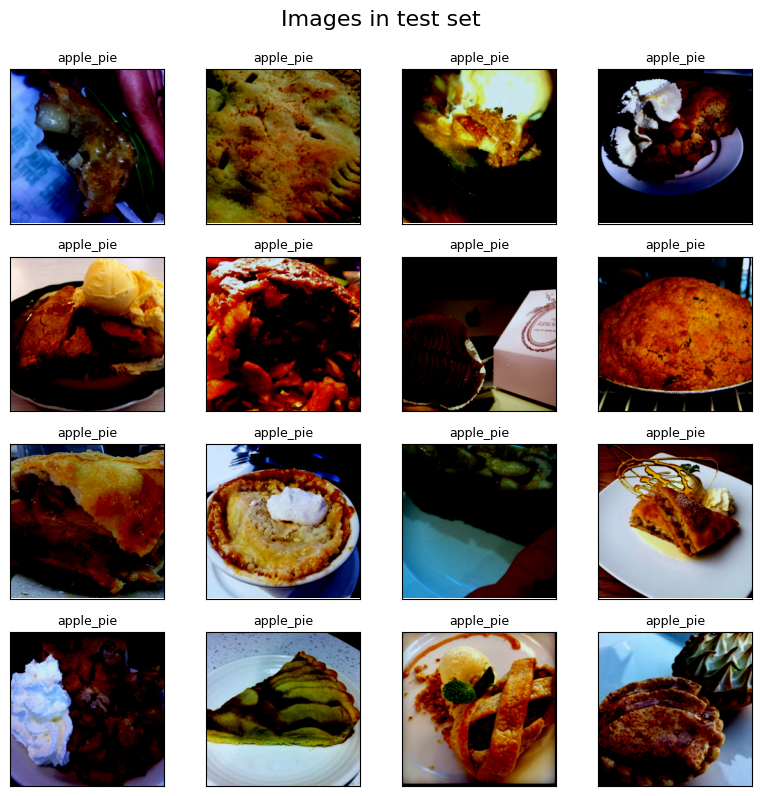

In [12]:
# get one batch of test set images
images, labels = next(iter(test_dataloader))

# check the results of preprocessing
fig = plt.figure(figsize=(8, 8))


for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    img = images[i].numpy().transpose(1,2,0)
    img = img / np.amax(img)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    ax.set_title(classes[labels[i]], fontsize=9)

plt.suptitle('Images in test set',
            fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

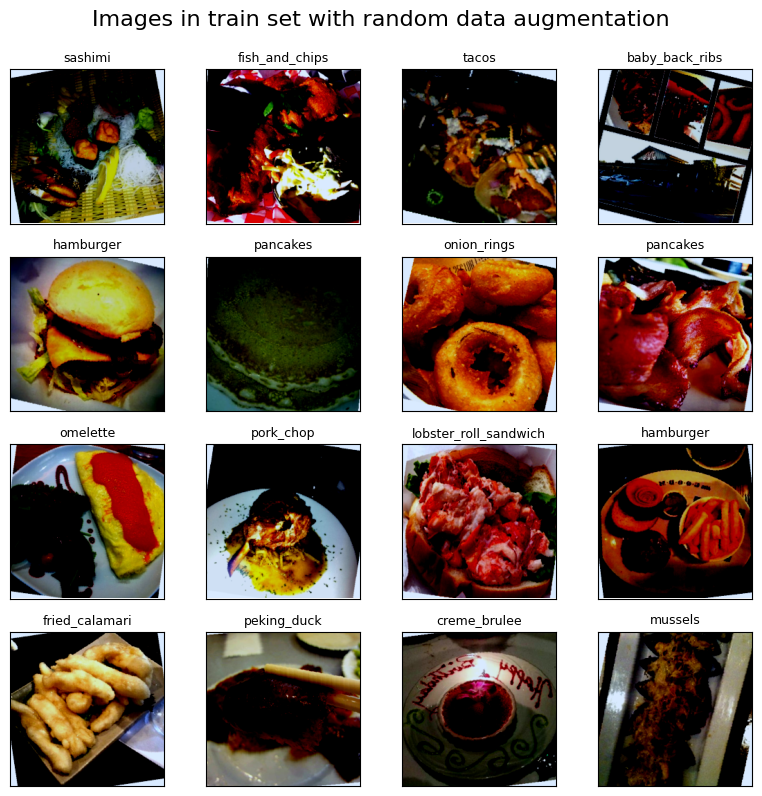

In [13]:
# check the results of preprocessing and data augmentation

# get one batch of train

images, labels = next(iter(train_dataloader))

fig = plt.figure(figsize=(8, 8))

for i in range(16):
    ax = fig.add_subplot(4, 4, i+1, xticks=[], yticks=[])
    img = images[i].numpy().transpose(1,2,0)
    img = img / np.amax(img)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    ax.set_title(classes[labels[i]], fontsize=9)

plt.suptitle('Images in train set with random data augmentation',
             fontsize=16, y=0.99)
plt.tight_layout()
plt.show()

## Model

In [15]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [16]:
model = models.resnext101_64x4d(pretrained=True,progress=True)

/home/buiniy_yarik/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/buiniy_yarik/anaconda3/envs/torch_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt101_64X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt101_64X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [18]:
class Net(nn.Module):
    def __init__(self, num_classes=101):
        super(Net, self).__init__()
        self.net = models.resnext101_64x4d(pretrained=True,progress=True)
        self.net.trainable = False
        self.net.fc = nn.Sequential(nn.Linear(2048, 1024),
                                    nn.ReLU(),
                                    nn.Dropout(p=0.3),
                                    nn.Linear(1024, num_classes))

        # # for densenet 161
        # self.net = models.densenet161(pretrained=True, progress=True)
        # self.net.trainable = False
        # self.net.fc = nn.Linear(1000, 101)

    def forward(self, x):
        return self.net(x)


model = Net(num_classes=len(classes))
model = model.to(device)
print(model)

Net(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [19]:
# freeze first few layers
for i, param in enumerate(model.parameters()):
    if i < 100:
        param.requires_grad = False

In [20]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, threshold=0.01, patience=4, verbose=True)


In [20]:
epochs = 30
# model_name = 'wide_resnet.pt'
# model_name = 'resnet-50.pt'
# model_name = 'densenet-201.pt'
model_name = 'resnext-101.pt'

def train(model, train_loader, val_loader, optimizer, scheduler, model_name, epochs):

    early_stop_count = 0
    early_stop_patience = 6
    best_acc = 0.0

    for epoch in range(epochs):

        # training
        model.train()
        correct = 0
        train_loss = 0.0
        tbar = tqdm(train_loader, desc='Training', position=0, leave=True)
        for i, data in enumerate(tbar):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss

            outputs = outputs.argmax(dim=1)
            correct += (outputs == labels).sum().item()
            acc = 100.0 * correct / ((i + 1) * train_loader.batch_size)
            tbar.set_description(f'Epoch: {epoch + 1}, loss: {loss.item():.4f}, accuracy: {acc:.4f}%')

        train_acc = 100.0 * correct / len(train_loader.dataset)
        train_loss /= (len(train_loader.dataset) / batch_size)

        # validation
        model.eval()
        with torch.no_grad():
            correct = 0
            val_loss = 0.0
            vbar = tqdm(val_loader, desc='Validation', position=0, leave=True)
            for data in vbar:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                val_loss += criterion(outputs, labels)
                outputs = outputs.argmax(dim=1)
                correct += (outputs == labels).sum().item()

            val_acc = 100.0 * correct / len(val_loader.dataset)
            val_loss /= (len(val_loader.dataset) / batch_size)

        print(f'\nEpoch: {epoch + 1}/{epochs}')
        print(f'Train loss: {train_loss}, Train accuracy: {train_acc}%')
        print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}%\n')

        scheduler.step(val_loss)

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), model_name)
            early_stop_count = 0
            print('Accuracy improved, model saved\n')
        else:
            early_stop_count += 1

        if early_stop_count == early_stop_patience:
            print('Early stopping initiated...')
            print(f'Best accuracy achieved: {best_acc:.4f}% at {epoch - early_stop_patience} epoch')
            print(f'Model saved as {model_name}')
            break


train(model, train_dataloader, val_dataloader, optimizer, scheduler, model_name, epochs)

Validation: 100%|██████████| 474/474 [00:32<00:00, 14.38it/s]



Epoch: 1/30
Train loss: 1.5284768342971802, Train accuracy: 62.42244224422442%
Validation loss: 0.8252458572387695, Validation accuracy: 78.2904290429043%

Accuracy improved, model saved



Validation: 100%|██████████| 474/474 [00:32<00:00, 14.37it/s]



Epoch: 2/30
Train loss: 0.6604940295219421, Train accuracy: 82.1947194719472%
Validation loss: 0.7581024765968323, Validation accuracy: 80.67986798679868%

Accuracy improved, model saved



Validation: 100%|██████████| 474/474 [00:32<00:00, 14.77it/s]



Epoch: 3/30
Train loss: 0.41543713212013245, Train accuracy: 88.3003300330033%
Validation loss: 0.763883113861084, Validation accuracy: 81.29372937293729%

Accuracy improved, model saved



Validation: 100%|██████████| 474/474 [00:31<00:00, 15.19it/s]



Epoch: 4/30
Train loss: 0.276952862739563, Train accuracy: 92.03795379537954%
Validation loss: 0.8124092817306519, Validation accuracy: 81.03630363036304%



Validation: 100%|██████████| 474/474 [00:31<00:00, 15.23it/s]



Epoch: 5/30
Train loss: 0.20181289315223694, Train accuracy: 93.96369636963696%
Validation loss: 0.8488816618919373, Validation accuracy: 81.08910891089108%



Validation: 100%|██████████| 474/474 [00:29<00:00, 16.26it/s]



Epoch: 6/30
Train loss: 0.1555922031402588, Train accuracy: 95.31848184818482%
Validation loss: 0.9215046167373657, Validation accuracy: 80.46204620462046%



Validation: 100%|██████████| 474/474 [00:28<00:00, 16.81it/s]



Epoch: 7/30
Train loss: 0.12899735569953918, Train accuracy: 96.0049504950495%
Validation loss: 0.9389627575874329, Validation accuracy: 80.13201320132013%

Epoch 00007: reducing learning rate of group 0 to 2.0000e-05.


Validation: 100%|██████████| 474/474 [00:28<00:00, 16.80it/s]



Epoch: 8/30
Train loss: 0.053188592195510864, Train accuracy: 98.42739273927393%
Validation loss: 0.9127709269523621, Validation accuracy: 82.67986798679868%

Accuracy improved, model saved



Validation: 100%|██████████| 474/474 [00:28<00:00, 16.81it/s]



Epoch: 9/30
Train loss: 0.028545770794153214, Train accuracy: 99.16006600660066%
Validation loss: 0.958535373210907, Validation accuracy: 82.68646864686468%

Accuracy improved, model saved



Validation: 100%|██████████| 474/474 [00:28<00:00, 16.80it/s]



Epoch: 10/30
Train loss: 0.02262812852859497, Train accuracy: 99.3069306930693%
Validation loss: 0.9732720255851746, Validation accuracy: 82.6996699669967%

Accuracy improved, model saved



Epoch: 11, loss: 0.1392, accuracy: 99.4318%:  67%|██████▋   | 1264/1894 [03:03<01:31,  6.88it/s]

In [ ]:
# !pip uninstall gdown -y && pip install gdown
# !gdown -V

In [ ]:
# import gdown

# # Download trained model
# url = 'https://drive.google.com/file/d/1G8SArvbtWnOvqMgEXiM094gMtIS3R9YD/view?usp=sharing'
# output = 'resnet50.pt'
# gdown.download(url, output, quiet=False)

In [21]:
model = Net()
model.load_state_dict(torch.load('resnext-101.pt'))
model = model.to(device)

In [22]:
def test(model, test_loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = outputs.argmax(dim=1)
            correct += (outputs == labels).sum().item()

    test_acc = 100.0 * correct / len(test_loader.dataset)

    print(f'Test accuracy: {test_acc:.1f}%')

test(model, test_dataloader)

Test accuracy: 87.3%


In [23]:
# get one batch of test images
images, labels = next(iter(test_dataloader))

# get sample outputs
outputs = model(images.to(device))
outputs = outputs.argmax(dim=1)

images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(11, 11))
for i in range(25):
    ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
    img = images[i].transpose(1,2,0)
    img = img / np.amax(img)
    img = np.clip(img, 0, 1)
    ax.imshow(np.squeeze(img))
    ax.set_title('{} ({})'.format(
        str(classes[outputs[i]]), str(classes[labels[i]])),
        color=('g' if outputs[i]==labels[i] else 'r'),
        fontsize=7)


plt.suptitle('Predictions and true labels',
             fontsize=16, y=0.93)
plt.show()